# Code for getting all results
In this notebook, you can build/load representations and train models.

Oh, and also tikz plotting

## Loading all Models and building representations

In [9]:
import torch
import numpy as np
import time

from collections import defaultdict
from typing import List
from conllu import parse_incr, TokenList
from torch import Tensor
from transformers import GPT2Model, GPT2Tokenizer
CUTOFF = None
from lstm.model import RNNModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
transformer = GPT2Model.from_pretrained('distilgpt2', output_hidden_states=True)
print("GPT2 Model ready")
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
print("GPT2 Tokenizer ready")

Model ready
Tokenizer ready


In [2]:
# XLNet
from transformers import XLNetModel, XLNetTokenizer
XLNet = XLNetModel.from_pretrained('xlnet-large-cased', output_hidden_states=True)
print("I have loaded XLNet!")
XLNet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
print("I have loaded the XLNet tokenizer!")

I have loaded XLNet!
I have loaded the XLNet tokenizer!


In [ ]:
# Transformer XL
from transformers import TransfoXLTokenizer, TransfoXLModel
transfo_XL = TransfoXLModel.from_pretrained('transfo-xl-wt103')
print("I have loaded the transformer XL model")
transfo_XL_tokenizer = TransfoXLTokenizer.from_pretrained('transfo-xl-wt103')
print("I have loaded the transformer XL Tokenizer")

In [3]:
# The Gulordava LSTM model can be found here: 
# https://drive.google.com/open?id=1w47WsZcZzPyBKDn83cMNd0Hb336e-_Sy
#
# N.B: I have altered the RNNModel code to only output the hidden states that you are interested in.
# If you want to do more experiments with this model you could have a look at the original code here:
# https://github.com/facebookresearch/colorlessgreenRNNs/blob/master/src/language_models/model.py
#
model_location = 'lstm/gulordava.pt'
lstm = RNNModel('LSTM', 50001, 650, 650, 2)
lstm.load_state_dict(torch.load(model_location))


# This LSTM does not use a Tokenizer like the Transformers, but a Vocab dictionary that maps a token to an id.
with open('lstm/vocab.txt') as f:
    w2i = {w.strip(): i for i, w in enumerate(f)}

vocabLSTM = defaultdict(lambda: w2i["<unk>"])
vocabLSTM.update(w2i)
i2w = { w2i[k]:k for k in w2i}
print("Loaded LSTM!")

## Load All Data

In [10]:
from utils import create_or_load_pos_data
from save_both import create_or_load_both_data
from controltasks import save_or_load_pos_controls 
from datasets import find_distribution, POSDataset
import torch.utils.data as data 
import time

"""
Change this piece of malevolent code that says CUTOFF = 100 or CUTOFF = 20
"""
CUTOFF = None

def get_transformer_pos_reps(transformer, tokenizer, cutoff=CUTOFF, extra_transformer=None):
    """
    Ugly function that either builds representations for a transformer or retrieves pickled ones if they exist.
    Running this takes loooong and is not recommended.
    Requests for all pickled files can be sent to annaproxy@protonmail.com
    """
    
    train_x, train_y, vocab, words_train = create_or_load_pos_data("train", 
                                                                   transformer, 
                                                                   tokenizer, 
                                                                   cutoff=CUTOFF,
                                                                   extra_transformer = extra_transformer
                                                                  ,shuffled=False)
    dev_x, dev_y, vocab, words_dev = create_or_load_pos_data("dev", 
                                                             transformer, 
                                                             tokenizer, 
                                                             vocab, 
                                                             cutoff=CUTOFF,
                                                             extra_transformer = extra_transformer, 
                                                             shuffled=False)
    
    test_x, test_y, vocab, words_test = create_or_load_pos_data("test", 
                                                                transformer, 
                                                                tokenizer, 
                                                                vocab, 
                                                                cutoff=CUTOFF,
                                                                extra_transformer = extra_transformer,
                                                                shuffled=False)

    # Flatten the wordlists so we have one big list of words for all set types
    flatten_train = [word for sublist in words_train for word in sublist]
    flatten_dev   = [word for sublist in words_dev for word in sublist]
    flatten_test  = [word for sublist in words_test for word in sublist]
    
    # Generate a distribution over tags, useful for control task
    dist = find_distribution(data.DataLoader(POSDataset(train_x, train_y), batch_size=1))
    ypos_train_control, ypos_dev_control, ypos_test_control = save_or_load_pos_controls(
        train_x, train_y, [flatten_train, flatten_dev, flatten_test], dist)

    return train_x, train_y, \
           dev_x, dev_y, \
           test_x, test_y



### Saving representations of models in variables

In [ ]:
# Representations for LSTM and our main transformer, GPT-2
train_x, train_y, dev_x, dev_y, test_x, test_y = get_transformer_reps(None,None,None, 'RNN')
train_xgpt , train_ygpt , dev_xgpt , dev_ygpt , test_xgpt , test_ygpt = get_transformer_reps(None,None,None, 'transformer')

In [12]:
# For XLNet
train_x_XLNet, train_y_XLNet, \
           dev_x_XLNet, dev_y_XLNet, \
           test_x_XLNet, test_y_XLNet = \
                    get_transformer_reps(None,None, extra_transformer='XLNet')

USING SAVE corpus/transformer_postrain_XLNet_shuffled.pickle
USING SAVE corpus/transformer_posdev_XLNet_shuffled.pickle
USING SAVE corpus/transformer_postest_XLNet_shuffled.pickle


In [7]:
train_xy_XLNet = create_or_load_structural_data("train", None, None,extra_transformer='XLNet')
dev_xy_XLNet = create_or_load_structural_data("dev", None, None,extra_transformer='XLNet')
test_xy_XLNet = create_or_load_structural_data("test", None, None,extra_transformer='XLNet')

USING SAVE FILE corpus/transformer_structuraltrain_XLNet.pickle
USING SAVE FILE corpus/transformer_structuraldev_XLNet.pickle
USING SAVE FILE corpus/transformer_structuraltest_XLNet.pickle


In [13]:
# Build TransformerXL
train_x_TransformerXL, train_y_TransformerXL,  \
           dev_x_TransformerXL, dev_y_TransformerXL,  \
           test_x_TransformerXL, test_y_TransformerXL = get_transformer_reps(None,None ,None ,extra_transformer='TransformerXL')

# Build tree data
from tree_utils import create_or_load_structural_data
train_xy_TransformerXL = create_or_load_structural_data("train", None, None,extra_transformer='TransformerXL')
dev_xy_TransformerXL = create_or_load_structural_data("dev", None, None,extra_transformer='TransformerXL')
test_xy_TransformerXL = create_or_load_structural_data("test", None, None,extra_transformer='TransformerXL')

USING SAVE corpus/transformer_postrain_TransformerXL_shuffled.pickle
USING SAVE corpus/transformer_posdev_TransformerXL_shuffled.pickle
USING SAVE corpus/transformer_postest_TransformerXL_shuffled.pickle


In [ ]:
# POS Data for LSTM
train_xL, train_yL, vocab, _ = create_or_load_pos_data("train", lstm, vocabLSTM, cutoff=CUTOFF)
dev_xL, dev_yL, vocab, _ = create_or_load_pos_data("dev", lstm, vocabLSTM, vocab, cutoff=CUTOFF)
test_xL, test_yL, vocab, _ = create_or_load_pos_data("test", lstm, vocabLSTM, vocab, cutoff=CUTOFF)

In [8]:
# POS controls are the same for everyone.
ypos_train_control, ypos_dev_control, ypos_test_control = save_or_load_pos_controls()

## PoS Models

In [14]:
# DIAGNOSTIC CLASSIFIER
import torch.nn as nn
import copy
class POSProbe(nn.Module):
    def __init__(self, repr_size, pos_size, hidden_size = 0, dropout=0):
        """
        Constructs a simple MLP (hidden_size > 0) or linear probe (hidden_size=0)
        """
        super().__init__()
        if hidden_size == 0:
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(repr_size, pos_size))
        else:
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(repr_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(hidden_size, pos_size)
            )
        
    def forward(self, x):
        return self.linear(x)
    
def eval_given_dataloader(loader, model):
    """Evaluate your POS probe"""
    model.eval()
    correct = 0.0
    total = 0.0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs,dim=1)
        c = torch.sum(torch.eq(preds, y))
        correct += c.item()
        total += y.shape[0]
    return correct/total
    
def train(my_model, train_loader, dev_loader, epoch_amount = 10, warmup_steps = 5, print_all=False):
    """
    Given a model, train_loader and dev_loader
    
    Returns state_dict for the best epoch
    """
    ce = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(my_model.parameters(), lr=1e-3)
    patience = 3
    best_model = None
    prev_dev_acc = 0.0
    best_dev_acc = 0.0
    best_epoch = 0
    for i in range(epoch_amount):
        my_model.train()
        epoch_correct = 0.0
        epoch_total = 0.0
        for x,y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
            outputs = my_model(x)
            preds = torch.argmax(outputs,dim=1)
            correct = torch.sum(torch.eq(preds, y))
            accuracy = correct.item()/y.shape[0]
            loss = ce(outputs, y)

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            epoch_correct += correct.item()
            epoch_total += y.shape[0]
            
        dev_acc = eval_given_dataloader(dev_loader, my_model)
        
        if print_all:
            print("Epoch",i,"accuracy", epoch_correct/epoch_total, dev_acc)        
        if dev_acc < prev_dev_acc and i > warmup_steps:
            patience -= 1
        else:
            patience = 2
        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            best_model = copy.deepcopy(my_model.state_dict())
            best_epoch = i
        prev_dev_acc = dev_acc
        if patience == 0:
            #print("Early stopping")
            break
    return best_model, best_epoch

In [ ]:
# MLP vs LINEAR
# Dropout 0.0 0.2 0.4 0.6 0.8 
# POS CONTROLPOS
# RNN vs Transformer
# result_dict[task][model][mlp][dropout][seed] -> bestmodel: statedict, val_acc: float, test_acc:float
import pickle
import os 

def eval_model(task, model_type, hidden_size, dropout, seed):
    """Evaluates one probe on model with hyperparameters hidden_size and dropout."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if model_type == 'lstm':
        x_train = train_x
        x_dev = dev_x
        x_test = test_x
        y_train = train_y
        y_dev = dev_y
        y_test = test_y
    elif model_type == 'transformer':
        x_train = train_xgpt
        x_dev = dev_xgpt
        x_test = test_xgpt
        y_train = train_ygpt
        y_dev = dev_ygpt
        y_test = test_ygpt
    elif model_type == 'XLNet':
        x_train = train_x_XLNet
        x_dev   = dev_x_XLNet
        x_test  = test_x_XLNet
        y_train = train_y_XLNet
        y_dev = dev_y_XLNet
        y_test = test_y_XLNet
    elif model_type == 'TransformerXL':
        x_train = train_x_TransformerXL
        x_dev = dev_x_TransformerXL
        x_test = test_x_TransformerXL
        y_train = train_y_TransformerXL
        y_dev = dev_y_TransformerXL
        y_test = test_y_TransformerXL
    else:
        raise ValueError("Not a valid model")
    
    if task == 'controlpos':
        y_train = ypos_train_control
        y_dev = ypos_dev_control
        y_test = ypos_test_control
    train_loader = data.DataLoader(POSDataset(x_train, y_train), batch_size=16, shuffle=True)
    dev_loader = data.DataLoader(POSDataset(x_dev, y_dev), batch_size=16)
    test_loader = data.DataLoader(POSDataset(x_test, y_test), batch_size=16)

    # Change model based on model type
    if model_type == 'transformer':
        dim = 768
    elif model_type == 'lstm': dim = 650
    else: dim = 1024
        
    model = POSProbe(dim, 17, hidden_size, dropout).to(device)
    
    best_state_dict, epochs = train(model, train_loader, dev_loader, 20, 4)
    model.load_state_dict(best_state_dict)
    dev_acc =  eval_given_dataloader(dev_loader, model)
    test_acc = eval_given_dataloader(test_loader, model)
    return model, dev_acc, test_acc, epochs

"""
This builds a giant dictionary of dev accuracies, test accuracies and saves state dicts for all combinations.
For POS task only!
"""
# Decide what models to run
model_list = [ 'lstm', 'transformer', 'TransformerXL', 'XLNet'] 

result_dict_mlp = {}   
for task in ['pos', 'control']:
    result_dict_mlp[task] = {}
    for model_type in model_list:
        result_dict_mlp[task][model_type]= {}
        for hidden_size in [0,256]:
            result_dict_mlp[task][model_type][hidden_size] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict_mlp[task][model_type][hidden_size][dropout] = {}
                for seed in [10,20,30]:
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed] = {}
                    state_dict, dev_acc, test_acc, epochs = eval_model(task, model_type, hidden_size, dropout, seed)
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['state_dict'] = state_dict
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['dev_acc'] = dev_acc
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['test_acc'] = test_acc
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['epochs'] = epochs
                    print(task,model_type,hidden_size,dropout,seed, epochs, test_acc)
                
with open("your_pickle_here.pickle", "wb") as f:
    pickle.dump(result_dict_mlp, f)

print("All results are safe. You can sleep peacefully. ")

## Structural

In [ ]:
from tree_utils import create_or_load_structural_data
from controltasks import save_or_load_struct_controls

# Load structural data for lstm from scratch
train_xyLSTM = create_or_load_structural_data("train", lstm, vocabLSTM, cutoff=CUTOFF)
dev_xyLSTM = create_or_load_structural_data("dev",     lstm, vocabLSTM, cutoff=CUTOFF)
test_xyLSTM = create_or_load_structural_data("test",   lstm, vocabLSTM, cutoff=CUTOFF)

# Load control tasks, same for everyone!
struct_train_control, struct_dev_control, struct_test_control = save_or_load_struct_controls(cutoff=CUTOFF)

# Example of how to load existing data given your model.
train_xy_XLNet = create_or_load_structural_data("train", None, None,extra_transformer='XLNet')
dev_xy_XLNet = create_or_load_structural_data("dev", None, None,extra_transformer='XLNet')
test_xy_XLNet = create_or_load_structural_data("test", None, None,extra_transformer='XLNet')

In [12]:
import torch.nn as nn
import torch


class StructuralProbe(nn.Module):
    """ Computes squared L2 distance after projection by a matrix.
    For a batch of sentences, computes all n^2 pairs of distances
    for each sentence in the batch.
    """
    def __init__(self, model_dim, rank, dropout = 0):
        super().__init__()
        self.probe_rank = rank
        self.model_dim = model_dim
        
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
        
        nn.init.uniform_(self.proj, -0.05, 0.05)
        #self.to(device)

    def forward(self, batch):
        """ Computes all n^2 pairs of distances after projection
        for each sentence in a batch.
        Note that due to padding, some distances will be non-zero for pads.
        Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j
        Args:
          batch: a batch of word representations of the shape
            (batch_size, max_seq_len, representation_dim)
        Returns:
          A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
        """
        batch = self.dropout(batch)
        transformed = torch.matmul(batch, self.proj)
        
        batchlen, seqlen, rank = transformed.size()
        
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1,2)
        
        diffs = transformed - transposed
        
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)

        return squared_distances

    
class L1DistanceLoss(nn.Module):
    """Custom L1 loss for distance matrices."""
    def __init__(self):
        super().__init__()

    def forward(self, predictions, label_batch, length_batch):
        """ Computes L1 loss on distance matrices.
        Ignores all entries where label_batch=-1
        Normalizes first within sentences (by dividing by the square of the sentence length)
        and then across the batch.
        Args:
          predictions: A pytorch batch of predicted distances
          label_batch: A pytorch batch of true distances
          length_batch: A pytorch batch of sentence lengths
        Returns:
          A tuple of:
            batch_loss: average loss in the batch
            total_sents: number of sentences in the batch
        """
        labels_1s = (label_batch != -1).float()
        predictions_masked = predictions * labels_1s
        labels_masked = label_batch * labels_1s
        total_sents = torch.sum((length_batch != 0)).float()
        squared_lengths = length_batch.pow(2).float()

        if total_sents > 0:
            loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=(1,2))
            normalized_loss_per_sent = loss_per_sent / squared_lengths
            batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
        
        else:
            batch_loss = torch.tensor(0.0)
        
        return batch_loss, total_sents

In [15]:
from torch import optim
import math
import tree_utils
import importlib
importlib.reload(tree_utils)
import copy


# I recommend you to write a method that can evaluate the UUAS & loss score for the dev (& test) corpus.
# Feel free to alter the signature of this method.
def evaluate_probe(probe, dataloader):
    loss_function =  L1DistanceLoss()
    probe.eval()
    total_loss = 0.0
    total_uuas = 0.0
    amt = 0.0
    for last ,(distances, embs, lengths) in enumerate(dataloader):
        embs = embs.to(device)
        distances = distances.to(device)
        lengths = lengths.to(device)
        amt += len(distances)
        outputs = probe(embs)
        loss = loss_function(outputs, distances, lengths)[0]
        total_loss += loss.item()
        for i in range(len(distances)):
            l = lengths[i]
            preds = outputs[i,0:l, 0:l]
            gold = distances[i,0:l, 0:l]
            
            u = tree_utils.calc_uuas(preds, gold)
            if math.isnan(u):
                amt -= 1
            # This if statement is a hack so nans don't get counted
            if u >= 0: total_uuas += u
            
    
    return total_loss/amt, total_uuas/amt

# Feel free to alter the signature of this method.
def train_structural(probe, dataloader, dev_dataloader, epochs=100, warmup_steps = 10,p =False):
    lr = 1e-3
    
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,patience=1)
    loss_function =  L1DistanceLoss()
    prev_dev_uuas = 0.0
    patience = 3
    best_epoch = 0
    best_model = None
    best_dev_uuas = 0.0
    for epoch in range(epochs):
        probe.train()
        for distances, embs, lengths in dataloader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            outputs = probe(embs)
            loss = loss_function(outputs, distances, lengths)[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        dev_loss, dev_uuas = evaluate_probe(probe, dev_dataloader)
        
        if p:
            print("Epoch", epoch, "Dev loss and uuas", dev_loss, dev_uuas)
        if dev_uuas < prev_dev_uuas and epoch > warmup_steps:
            patience -= 1
        else:
            patience = 3
        if dev_uuas > best_dev_uuas :
            best_dev_uuas  = dev_uuas 
            best_model = copy.deepcopy(probe.state_dict())
            best_epoch = epoch
        prev_dev_uuas  = dev_uuas 
        if patience == 0:
            break
        
    return best_model, best_epoch

In [ ]:

import pickle
import os 
import time 
from datasets import *
import torch.utils.data as data

def eval_model(task, model_type, rank, dropout, seed):
    """Evaluates a probe on the DEP/CONTROLDEP task."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if model_type == 'lstm':
        x_train = train_xyLSTM[1]
        x_dev = dev_xyLSTM[1]
        x_test = test_xyLSTM[1]
    elif model_type == 'transformer':
        x_train = train_xy[1]
        x_dev = dev_xy[1]
        x_test = test_xy[1]
    elif model_type == 'XLNet':
        x_train = train_xy_XLNet[1]
        x_dev   = dev_xy_XLNet[1]
        x_test  = test_xy_XLNet[1]
    elif model_type == 'TransformerXL':
        x_train = train_xy_TransformerXL[1]
        x_dev = dev_xy_TransformerXL[1]
        x_test = test_xy_TransformerXL[1]
    else:
        raise ValueError("No valid model!")
    
    if task == 'dep':
        y_train = train_xy_TransformerXL[0]
        y_dev = dev_xy_TransformerXL[0]
        y_test = test_xy_TransformerXL[0]
    else:
        y_train = struct_train_control
        y_dev = struct_dev_control
        y_test = struct_test_control
        
    train_loader = data.DataLoader(StructuralDataset(y_train, x_train), batch_size=32,collate_fn= pad_batch, shuffle=True)
    dev_loader = data.DataLoader(StructuralDataset(y_dev, x_dev), collate_fn= pad_batch,batch_size=32)
    test_loader = data.DataLoader(StructuralDataset(y_test, x_test),collate_fn= pad_batch, batch_size=32)

    model = StructuralProbe(768 if (model_type == 'transformer') else (650 if model_type == 'lstm' else 1024),
                            rank =rank, dropout=dropout).to(device)
    best_state_dict, epochs = train_structural(model, train_loader, dev_loader, epochs=30, warmup_steps=6)
    model.load_state_dict(best_state_dict)
    dev_acc =  evaluate_probe(model, dev_loader)
    test_acc = evaluate_probe(model, test_loader)
    return model, dev_acc, test_acc, epochs

print(device)
result_dict = {}  
torch.cuda.empty_cache()
for task in ['controldep', 'dep']:
    result_dict[task] = {}
    for model_type in ['TransformerXL']:
        result_dict[task][model_type]= {}
        for rank in [128]:
            result_dict[task][model_type][rank] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict[task][model_type][rank][dropout] = {}
                for seed in [10,20,30]:
                    #starttime = time.time()
                    result_dict[task][model_type][rank][dropout][seed] = {}
                    state_dict, dev_acc, test_acc, epochs = eval_model(task, model_type, rank, dropout, seed)
                    result_dict[task][model_type][rank][dropout][seed]['state_dict'] = state_dict
                    result_dict[task][model_type][rank][dropout][seed]['dev_acc'] = dev_acc[1]
                    result_dict[task][model_type][rank][dropout][seed]['test_acc'] = test_acc[1]
                    result_dict[task][model_type][rank][dropout][seed]['epochs'] = epochs
                    print(task,model_type,rank,dropout,seed, epochs, test_acc)
                    #stoptime = time.time() -starttime
                    #print('Time elapsed %s' % stoptime)
                    
with open("your_struct_results_here.pickle", "wb") as f:
    pickle.dump(result_dict, f)
print("All results are safe. You can sleep peacefully. ")


## Some Irrelevant Code

This plots some lengths and plots some tikz stuff!
It is not pretty.

In [23]:
corp = parse_corpus(os.path.join('data', 'en_ewt-ud-'+'train'+'.conllu'))

In [109]:
def print_tikz(real_edges, fake_edges, words, pos_tags, fake_pos_tags, split_name):
    with open(os.path.join( split_name+'.tikz'), 'a') as fout:
        string = """\\begin{dependency}[hide label, edge unit distance=.5ex]
        \\begin{deptext}[column sep=0.05cm]
        """ 
        string += "\\& ".join(['{\\scriptsize ' + x + '}' for x in pos_tags]) + " \\\\" + '\n'
        string += "\\& ".join(['{\\normalsize ' + x + '}' for x in words]) + " \\\\" + '\n'
        string += "\\& ".join(['{\\scriptsize\color{blue!60} ' + x + '}'  for x in fake_pos_tags]) + " \\\\" + '\n'
        
        string += "\\end{deptext}" + '\n'
        for i_index, j_index in real_edges:
            string += '\\depedge{{{}}}{{{}}}{{{}}}\n'.format(i_index+1,j_index+1, '.')
        for i_index, j_index in fake_edges:
            string += '\\depedge[edge style={{blue!60!}}, edge below]{{{}}}{{{}}}{{{}}}\n'.format(i_index+1,j_index+1, '.')
        string += '\\end{dependency}\n'
        fout.write('\n\n')
        fout.write(string)


from collections import Counter
undirected_edges = tree_utils.edges(tree_utils.create_mst(train_xy[0][966]))
directed_edges = []
fake_undirected_edges = tree_utils.edges(tree_utils.create_mst(struct_train_control[966]))
fake_directed_edges = []

for token in corp2[966]:
    current = (token['head']-1, token['id']-1)
    #print(tuple(sorted(tuple(current))) in undirected_edges, current)
    if token['head'] != 0: directed_edges.append(current)

#print(len(corp2[966]))
for edge in fake_undirected_edges:
    if edge[1] == 14 and edge[0] != 0:
        fake_directed_edges.append((edge[1],edge[0]))
    else:
        fake_directed_edges.append(edge)
    
length = 0
sents = 0
all_words = []
for token in corp2[:966]:
    sents += 1
    for z in token:
        length += 1
        all_words.append(z['form'])
for token in corp2[966:967]:
    for z in token:
        all_words.append(z['form'])
        
        
print(length, sents)
print(len(directed_edges)) 
print(len(undirected_edges))
print(len(fake_undirected_edges))
print(fake_directed_edges)
words = [z['form'] for z in corp2[966]]
pos_tags = [z['upostag'] for z in corp2[966]]
real_pos_tags = train_y[length:length+16]
fake_pos_tags = ypos_train_control[length:length+15]
print(len(fake_pos_tags), len(all_words))

print("words", all_words[length:length+15])
print(real_pos_tags)
print(fake_pos_tags)


#print(dists_check)
#print(dist)
reversed_dist_check = {k:v for v,k in dists_check.items()}
#print(reversed_dist_check)


real_pos_tags = [reversed_dist_check[dist[i.item()]] for i in real_pos_tags]
fake_pos_tags = [reversed_dist_check[dist[i]] for i in fake_pos_tags]
print([z for z in zip (pos_tags, real_pos_tags)])
print([z for z in zip(words,real_pos_tags)])
print([z for z in zip(words,fake_pos_tags)])
print_tikz(directed_edges, fake_directed_edges, words, pos_tags, fake_pos_tags, 'tasks')


from collections import defaultdict
dists_check = defaultdict(lambda:0)
for sent in corp2:
    for token in sent:
        dists_check[token['upostag']] += 1
        


21282 966
14
14
14
[(0, 1), (0, 7), (14, 2), (14, 3), (0, 4), (14, 8), (14, 10), (0, 13), (0, 9), (0, 6), (14, 12), (0, 5), (0, 14), (0, 11)]
15 21297
words ['Imaginary', 'good', 'is', 'boring', ';', 'real', 'good', 'is', 'always', 'new', ',', 'marvelous', ',', 'intoxicating', '.']
tensor([ 2,  3,  7,  2,  1,  2,  3,  7, 12,  2,  1,  2,  1,  2,  1,  1])
[ 6  3  1  7  4  3  3  1  2 12 14  1 14  3  8]
[('ADJ', 'ADJ'), ('NOUN', 'NOUN'), ('AUX', 'AUX'), ('ADJ', 'ADJ'), ('PUNCT', 'PUNCT'), ('ADJ', 'ADJ'), ('NOUN', 'NOUN'), ('AUX', 'AUX'), ('ADV', 'ADV'), ('ADJ', 'ADJ'), ('PUNCT', 'PUNCT'), ('ADJ', 'ADJ'), ('PUNCT', 'PUNCT'), ('ADJ', 'ADJ'), ('PUNCT', 'PUNCT')]
[('Imaginary', 'ADJ'), ('good', 'NOUN'), ('is', 'AUX'), ('boring', 'ADJ'), (';', 'PUNCT'), ('real', 'ADJ'), ('good', 'NOUN'), ('is', 'AUX'), ('always', 'ADV'), ('new', 'ADJ'), (',', 'PUNCT'), ('marvelous', 'ADJ'), (',', 'PUNCT'), ('intoxicating', 'ADJ'), ('.', 'PUNCT')]
[('Imaginary', 'ADP'), ('good', 'NOUN'), ('is', 'PUNCT'), ('borin

In [133]:
from datasets import StructuralDataset

with open("structresults_and_models.pickle", "rb") as f:
    dd = pickle.load(f)

test_loader_transformer = data.DataLoader(StructuralDataset(*test_xy), batch_size=1, shuffle=False)
test_loader_lstm = data.DataLoader(StructuralDataset(*test_xyLSTM), batch_size=1, shuffle=False)


def uuas_per_length(model, test_loader):
    length_amount_dict = defaultdict(lambda:0)
    length_uuas_dict = defaultdict(lambda:0)
    result = dict()
    model.eval()
    with torch.no_grad():
        for distances, embs, lengths in test_loader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)

            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            #print(lengths)
            outputs = model(embs)
            l = lengths[0].item()
            preds = outputs[0,0:l, 0:l]
            gold = distances[0,0:l, 0:l]

            u = tree_utils.calc_uuas(preds, gold)
            #print(l, u)
            if not math.isnan(u):
                length_amount_dict[l] +=1
                length_uuas_dict[l] += u

    for k in sorted(list(length_uuas_dict.keys())):
        result[k] = length_uuas_dict[k]/length_amount_dict[k]
    return result

def uuas_averaged_per_seed(model, test_loader):
    result = defaultdict(lambda:0)
    for seed in [10,20,30]:
        specific_results = uuas_per_length(model[seed]['state_dict'], test_loader)
        for k in specific_results:
            result[k] += specific_results[k]
            
    for k in result:
        result[k] /=3 
    return result

transformer64 = uuas_averaged_per_seed(dd['dep']['transformer'][64][0], test_loader_transformer)
lstm64 = uuas_averaged_per_seed(dd['dep']['lstm'][64][0], test_loader_lstm)

In [136]:
transformer16 = uuas_averaged_per_seed(dd['dep']['transformer'][16][0], test_loader_transformer)
lstm16 = uuas_averaged_per_seed(dd['dep']['lstm'][16][0], test_loader_lstm)

In [139]:
transformer128 = uuas_averaged_per_seed(dd['dep']['transformer'][128][0], test_loader_transformer)
lstm128 = uuas_averaged_per_seed(dd['dep']['lstm'][128][0], test_loader_lstm)

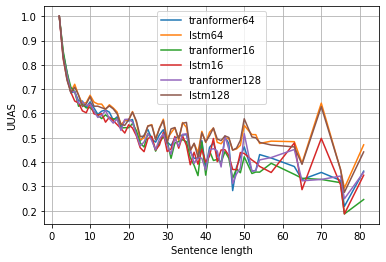

In [142]:
plt.plot(*zip(*transformer64.items()), label='tranformer64')
plt.plot(*zip(*lstm64.items()),label='lstm64')
plt.plot(*zip(*transformer16.items()), label='tranformer16')
plt.plot(*zip(*lstm16.items()),label='lstm16')
plt.plot(*zip(*transformer128.items()), label='tranformer128')
plt.plot(*zip(*lstm128.items()),label='lstm128')
plt.legend()
plt.grid()
plt.xlabel("Sentence length")
plt.ylabel("UUAS")
plt.show()

P.S. My java code from five years ago is better structured than this at times